In [1]:
#For multiple GPU process the following versions are required
#keras =2.1.3
#tensorflow=1.4

In [1]:
from glob import glob
import scipy.misc
import pandas as pd
%matplotlib inline
import imageio
import os, errno
from pathlib import PurePath
import skimage.transform, skimage.io
import matplotlib.pyplot as plt
import shutil
import numpy as np
from tqdm import tqdm


from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Dropout, Lambda
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras import backend as K
from skimage.morphology import label

/home/fali/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X_train_files = glob('stage1_train/**/images/*.png')
sizes_train = []
for file in (X_train_files):
    imgg = imageio.imread(file)
    sizes_train.append(imgg.shape)

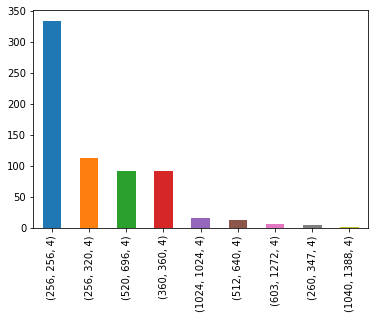

In [3]:
pd.Series(sizes_train).value_counts().plot(kind = 'bar')

## The next three cells only need to be run once

In [62]:
# #Lets resize all the images to (256,256,4) once, this will greatly speed up 
# #training when using a generator.

# image_shape = (256,256,3)

# for path in  tqdm(glob('stage1_train/**/images/*.png', recursive=True)):
#     path_parts = PurePath(path).parts
#     directory = os.path.join('resized_train',*path_parts[1:-2])
#     file_name = os.path.basename(path)
#     try:
#         os.makedirs(directory)
#     except OSError as e:
#         if e.errno != errno.EEXIST:
#             raise
           
#     imgg = skimage.transform.resize(scipy.misc.imread(path) , image_shape, mode='constant' , preserve_range=True)
    
#     scipy.misc.imsave(os.path.join(directory, file_name),imgg[:,:,:4])

In [28]:
# #lets combine the masks into one image and resize that image

# image_shape = (256,256)
# Y = []
# for mask_paths in  tqdm(glob('stage1_train/**/masks', recursive=True)):
#     mask_files = os.path.join(mask_paths,'*.png')
#     #get the size of the current mask to create an empty numpy array
#     first_mask_size = scipy.misc.imread(glob(mask_files)[0]).shape
#     mask = np.zeros(first_mask_size)
#     for mask_path in glob(mask_files):
        
#         mask_ = scipy.misc.imread(mask_path)
#         np.maximum(mask, mask_, out=mask)
#     #print(np.histogram(mask))
    
#     path_parts = PurePath(mask_paths).parts
#     directory = os.path.join('resized_train',*path_parts[1:-1], )
#     file_name = path_parts[1]+'_mask.png'
#     try:
#         os.makedirs(directory)
#     except OSError as e:
#         if e.errno != errno.EEXIST:
#             raise
            
#     mask = skimage.transform.resize(mask, image_shape, mode='constant' , preserve_range=True).astype(bool).astype(np.float32)
#     #Y.append(mask)
#     scipy.misc.imsave(os.path.join(directory, file_name),mask)

In [11]:
# #lets split our data in to train and validation sets
# try:
#     shutil.rmtree('train/')
#     shutil.rmtree('valid/')
# except:
#     pass

# for typee in ['train','valid']:
#     os.makedirs(os.path.join(typee,'masks','files'))
#     os.makedirs(os.path.join(typee,'images','files'))

# for mask_file in glob('resized_train/**/*_mask.png', recursive=True):
#     #for file in glob(s+'/*.png'):
#     #images and masks should have the same name otherwise the generators won't sync
#     image_file = mask_file.replace('_mask','')
#     if np.random.rand(1)[0] < 0.8:
#         shutil.copy(mask_file, dst=os.path.join('train','masks','files',os.path.basename(image_file)))
#         shutil.copy(image_file, dst=os.path.join('train','images','files',os.path.basename(image_file)))

#     else:
#         shutil.copy(mask_file, dst=os.path.join('valid','masks','files',os.path.basename(image_file)))
#         shutil.copy(image_file, dst=os.path.join('valid','images','files',os.path.basename(image_file)))


In [4]:
image_gen = ImageDataGenerator(rescale = 1./255)
mask_gen = ImageDataGenerator(rescale = 1./255)

img_height = 256
img_width = 256

batch_size_ = 16

In [5]:
# For training data
seed_train = (np.random.rand(1) * 5e3).astype(int)[0] # so both input and labels are synced
train_data_gen = image_gen.flow_from_directory('train/images/',
batch_size = batch_size_, seed=seed_train, class_mode= None)

train_mask_gen = mask_gen.flow_from_directory('train/masks/',
batch_size = batch_size_, seed=seed_train, class_mode= None, color_mode = 'grayscale')

train_generator = zip(train_data_gen, train_mask_gen)

Found 534 images belonging to 1 classes.
Found 534 images belonging to 1 classes.


In [6]:
# For validation data
seed_valid = (np.random.rand(1) * 5e3).astype(int)[0]  # so both input and labels are synced
val_data_gen = image_gen.flow_from_directory('valid/images/',
batch_size = batch_size_, seed=seed_valid, class_mode= None)

val_mask_gen = mask_gen.flow_from_directory('valid/masks/',
batch_size = batch_size_, seed=seed_valid, class_mode= None, color_mode = 'grayscale')

valid_generator = zip(val_data_gen, val_mask_gen)

Found 136 images belonging to 1 classes.
Found 136 images belonging to 1 classes.


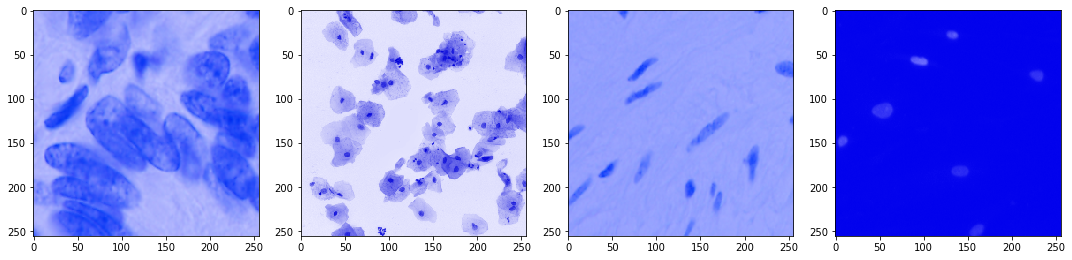

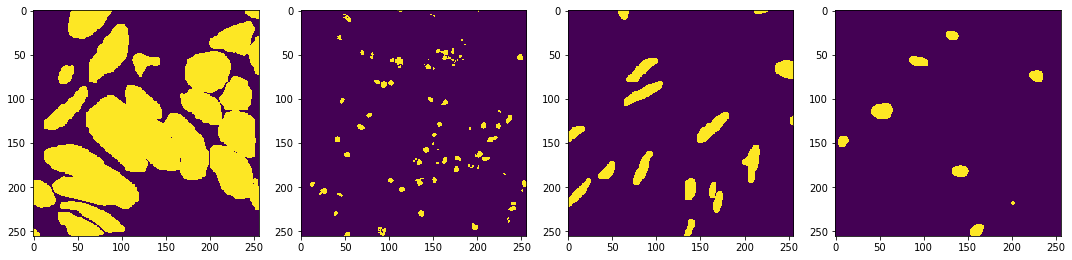

In [15]:
#Lets explore some outputs from generators
samples_images,samples_masks1 = next(train_generator)
samples_masks = np.squeeze(samples_masks1)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 15))
f.tight_layout()
ax1.imshow(samples_images[0])
ax2.imshow(samples_images[1])
ax3.imshow(samples_images[2])
ax4.imshow(samples_images[3])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 15))
f.tight_layout()
ax1.imshow(samples_masks[0])
ax2.imshow(samples_masks[1])
ax3.imshow(samples_masks[2])
ax4.imshow(samples_masks[3])


In [18]:
#lets confirm that the masks are still binary images
np.histogram(samples_masks1[10,:,:,0])

(array([47851,     0,     0,     0,     0,     0,     0,     0,     0,
        17685]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [29]:
#Reference & credit: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

#Model at following did not perform great: #reference https://github.com/vxy10/p5_VehicleDetection_Unet/blob/master/main_car_Unet_train_IoU.ipynb

def Unet():
    inputs = Input((256, 256, 3))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [30]:
#IoU Metric
eps = 1
def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + eps) / (K.sum(y_true_f) + K.sum(y_pred_f) + eps)


In [105]:
#model = get_unet()
model = Unet()

In [106]:
from keras.utils import multi_gpu_model

# Replicates `model` on 2 GPUs.
# This assumes that your machine has 2 available GPUs.
parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',IOU_calc])



In [109]:
parallel_model.fit_generator(train_generator, steps_per_epoch=32,epochs = 50,
                             validation_data=valid_generator,validation_steps = 8 )

Epoch 1/50
32/32 [==============================] - 47s 1s/step - loss: 0.6112 - acc: 0.8087 - IOU_calc: 0.1735 - val_loss: 0.4644 - val_acc: 0.8356 - val_IOU_calc: 0.1899
Epoch 2/50
32/32 [==============================] - 44s 1s/step - loss: 0.4257 - acc: 0.8531 - IOU_calc: 0.1496 - val_loss: 0.4426 - val_acc: 0.8421 - val_IOU_calc: 0.1412
Epoch 3/50
32/32 [==============================] - 45s 1s/step - loss: 0.4321 - acc: 0.8484 - IOU_calc: 0.1498 - val_loss: 0.4234 - val_acc: 0.8504 - val_IOU_calc: 0.1517
Epoch 4/50
32/32 [==============================] - 44s 1s/step - loss: 0.4258 - acc: 0.8507 - IOU_calc: 0.1507 - val_loss: 0.4444 - val_acc: 0.8372 - val_IOU_calc: 0.1630
Epoch 5/50
32/32 [==============================] - 44s 1s/step - loss: 0.4286 - acc: 0.8490 - IOU_calc: 0.1518 - val_loss: 0.4427 - val_acc: 0.8378 - val_IOU_calc: 0.1656
Epoch 6/50
32/32 [==============================] - 44s 1s/step - loss: 0.4240 - acc: 0.8512 - IOU_calc: 0.1508 - val_loss: 0.4172 - val_acc

In [2]:
####Save the Model
# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

#Load the model
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [7]:
sample_images, sample_masks = next(valid_generator)
predicted_masks = model.predict(sample_images)
predicted_masks[predicted_masks > 0.5] = 1

In [8]:
#let's see the spread of the mask values. These should be concentrated at 0 and 1
np.histogram(predicted_masks)

(array([739533,  37891,  21324,  16507,  14979,      0,      0,      0,
             0, 218342]),
 array([3.27434282e-05, 1.00029469e-01, 2.00026195e-01, 3.00022920e-01,
        4.00019646e-01, 5.00016372e-01, 6.00013097e-01, 7.00009823e-01,
        8.00006549e-01, 9.00003274e-01, 1.00000000e+00]))

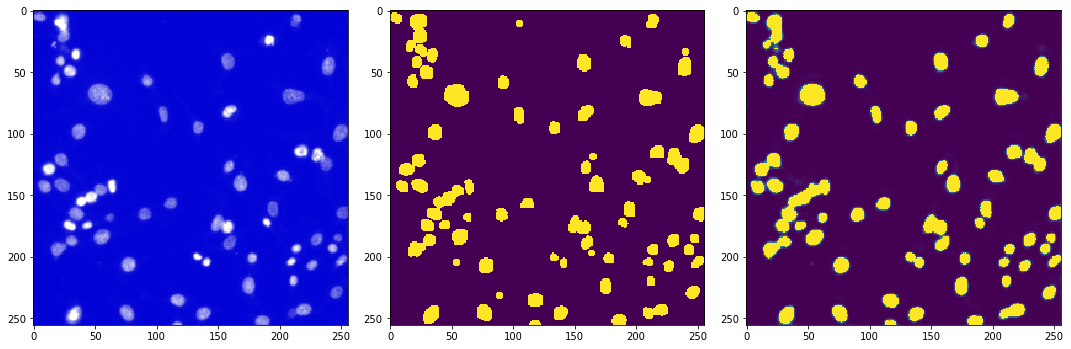

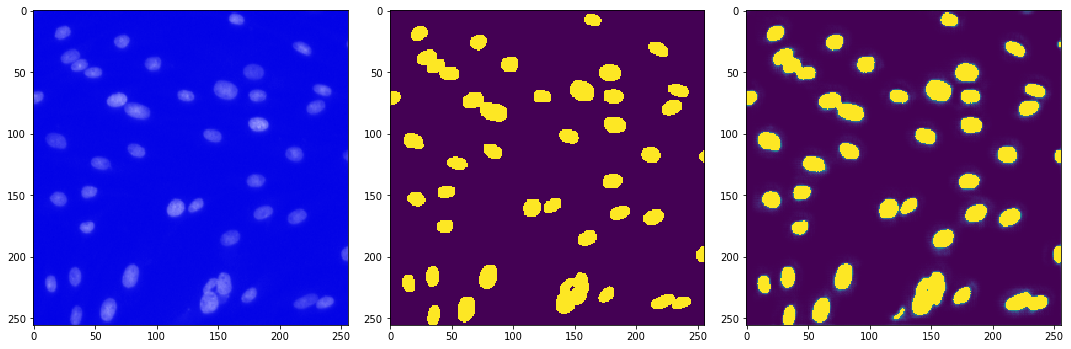

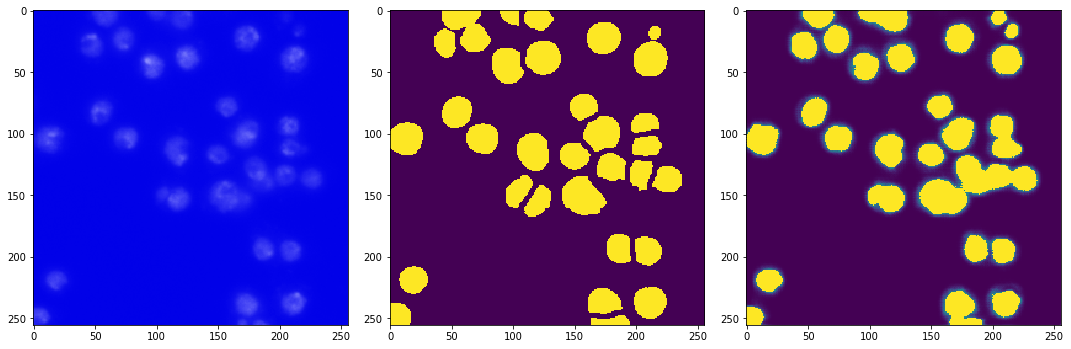

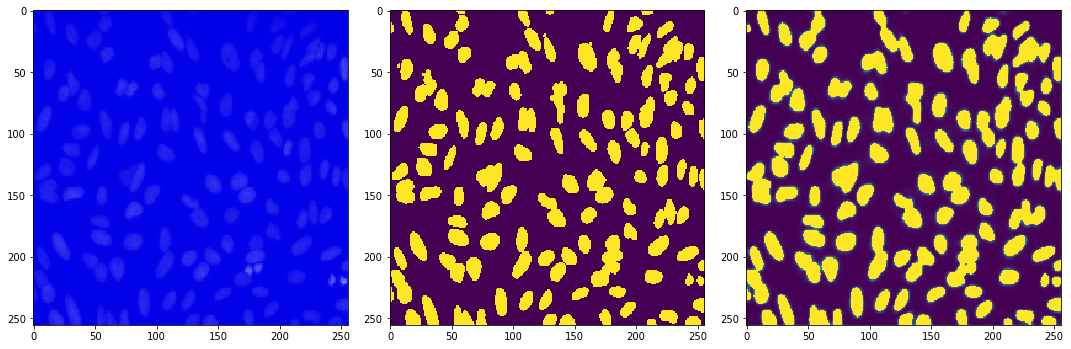

In [9]:
#compare results of model on validation data
for idx in range(4):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
    f.tight_layout()
    ax1.imshow(sample_images[idx])
    ax2.imshow(sample_masks[idx,:,:,0])
    ax3.imshow(predicted_masks[idx,:,:,0])


In [10]:
X_test_files = glob('stage1_test/**/images/*.png')
original_sizes_test = []
ori_test_imgs = []
test_images = np.zeros((len(X_test_files),256,256,3))
for idx,file in enumerate(X_test_files):
    imgg = skimage.io.imread(file)
    ori_test_imgs.append(imgg)
    original_sizes_test.append(imgg.shape)
    
    resized_img = skimage.transform.resize(imgg, output_shape=(256,256,imgg.shape[2]),preserve_range=True, mode='constant') 
    #remember to normalize the test image
    test_images[idx,:,:,:] = resized_img[:,:,:3]/255.0
    

## Get predictions on the resized and normalized test data

In [11]:
predictions = model.predict(test_images)

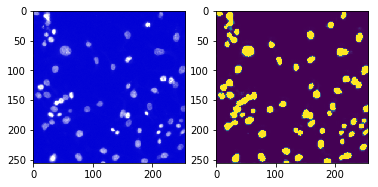

In [12]:
#inspect a predicted mask image
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(sample_images[0])
ax2.imshow(predicted_masks[0,:,:,0])

In [13]:
upscaled_test_predictions = []
for i in range(len(predictions)):
    
    temp_img = skimage.transform.resize(predictions[i,:,:,0], original_sizes_test[i][:2],mode='constant', preserve_range=True)
    upscaled_test_predictions.append(temp_img)

In [15]:
#Uncomment to compare original test images, resized test images and their predicted masks
# for idx,imgg in enumerate(upscaled_test_predictions):
#     f, (ax1, ax2, ax3) = plt.subplots(1,3)
#     ax1.imshow(ori_test_imgs[idx])
#     ax1.set_title(original_sizes_test[idx])
    
#     ax2.imshow(test_images[idx])
    
#     imgg[imgg > 0.33] = 1
#     ax3.imshow(imgg)


In [16]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.33):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [17]:
new_test_ids = []
rles = []
for idx, name in enumerate(X_test_files):
    id_ = os.path.basename(name).replace('.png','')
    rle = list(prob_to_rles(upscaled_test_predictions[idx]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [18]:
df = pd.DataFrame(new_test_ids, columns=['ImageId'])
df['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
df.to_csv('unet_submission.csv', index=False)

In [19]:
# make sure all 65 test images have masks present
len(df.ImageId.unique())

65

In [21]:
df[:10]

,ImageId,EncodedPixels
0,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,57097 2 57350 8 57604 11 57858 13 58113 15 583...
1,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,33039 5 33294 8 33550 9 33805 11 34061 11 3431...
2,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,25655 6 25910 8 26165 10 26421 11 26677 11 269...
3,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,29036 9 29291 12 29546 15 29802 16 30058 16 30...
4,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,62063 9 62317 13 62572 15 62827 17 63083 17 63...
5,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,51836 8 52089 12 52344 14 52599 15 52854 16 53...
6,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,18045 3 18298 10 18553 14 18808 16 19063 18 19...
7,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,42370 12 42624 17 42880 19 43135 21 43391 22 4...
8,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,4269 1 4521 10 4776 12 5031 15 5286 17 5542 18...
9,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,64467 6 64721 12 64977 13 65232 15 65488 15
